# Simulate trips counts with a toy model
This notebook attempts to look at what happens when we know the probabilities of our model choosing each mode and the actual numbers of each mode.
The toy model is just random choice. It randomly chooses trips to be car or ebike, with different chances depending on the actual mode.

This can help us better understand how our estimates behave.

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

### Ways to represent uncertain class probabilities
For two classes, we can use a Beta distribution. Here is a great interactive visualization of the beta distribution. https://www.acsu.buffalo.edu/~adamcunn/probability/beta.html \
For >2 classes - Dirichlet distribution.

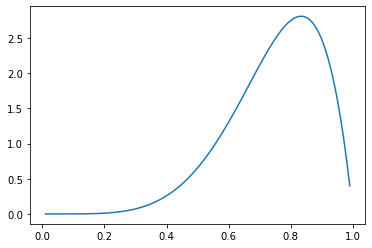

In [16]:
from scipy.stats import beta
import matplotlib.pyplot as plt

# Imagine you are looking at the distribution of the probability a trip is car.
# That's what I'm trying to represent here. See https://en.wikipedia.org/wiki/Beta_distribution. 
# If a and b are equal, then we have no reason to favor p(car) vs p(not car).
# Let p ~ Beta(a,b)
# E[p] = a/(a + b)
# Var(p) = ab/[(a+b)^2 * (a + b + 1)] 
a =  6
b = 2
x = np.arange (0.01, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y); plt.show()

#### Dirichlet example
Based on the example in https://numpy.org/doc/stable/reference/random/generated/numpy.random.dirichlet.html.
See also: https://en.wikipedia.org/wiki/Dirichlet_distribution

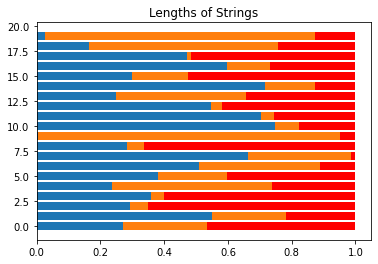

In [9]:
# If we cut a string into 3 pieces and each piece is meant to have some average length. What if we allow variation in each length?
# We set all three Dirichlet parameters to the same value, we favor no piece over the other.
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()
s = rng.dirichlet((1,1,1),20).transpose()
plt.barh(range(20), s[0])

plt.barh(range(20), s[1], left=s[0], color='tab:orange')

plt.barh(range(20), s[2], left=s[0]+s[1], color='r')

plt.title("Lengths of Strings"); plt.show()

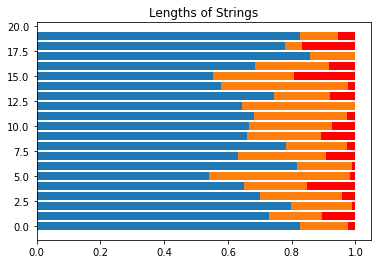

In [10]:
# If we want the distribtion concentrated more on the first string.
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()
s = rng.dirichlet((10,3,1),20).transpose()
plt.barh(range(20), s[0])

plt.barh(range(20), s[1], left=s[0], color='tab:orange')

plt.barh(range(20), s[2], left=s[0]+s[1], color='r')

plt.title("Lengths of Strings"); plt.show()

### Example of going from P(predicted | ground truth) to P(ground truth | predicted) using prior mode probabilities.
Ground truth is on the rows, predicted on columns

In [23]:
# Together, these to are like our confusion matrix.
p_sensed_given_actual_car = {"ebike": 0.4, "car": 0.6} 
p_sensed_given_actual_ebike = {"ebike": 0.6, "car": 0.4}

prior_mode_probs = {"car": 0.8, "ebike":  0.7}
row_normalized_confusion_matrix = pd.DataFrame({"ebike": p_sensed_given_actual_ebike, "car": p_sensed_given_actual_car})
likelihood_times_priors = row_normalized_confusion_matrix.multiply(pd.Series(prior_mode_probs), axis='rows')
normalizing_constants = likelihood_times_priors.sum(axis='rows')
prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()
prob_actual_given_predicted_df

,ebike,car
car,0.432432,0.631579
ebike,0.567568,0.368421


### A look at modeshare
**Note that as the true distribution of car vs ebike gets further from our prior mode distribution, 
our estimates for the counts get further from the truth. The distance in standard deviations also becomes larger.**
- if the prior probabilities are 50-50, then cases of 10-90 or 90-10 are where the estimate is worst.

In [24]:
# Note: in my simulation, the true chance of predicted mode given actual mode is the same as the value I use in my confusion matrix.
# This is not the case with real data - the mobilitynet confusion matrix approximates the true chances of predicted given actual.

def trip_set_simulator_mode_counts(n_car, n_ebike, trip_distance, NMC, prior_mode_probs,
                                p_sensed_given_actual_car, 
                                p_sensed_given_actual_ebike
                                ):
    '''
    Simulate mode count calculations for 2 modes: car and ebike.
    Start with a set of actual modes, and then assign sensed modes based on probabilities that depend on the actual mode.
        For example, if the actual mode is car and p_sensed_given_actual_car = [0.4,0.6], 
        then there is a 40% chance that we will predict ebike and 60% chance of predicting car.
    It might be better to reformat p_sensed_given_actual_car and p_sensed_given_actual_ebike as one row normalized confusion matrix input.

    Inputs:
    n_car: the number of actual car trips to include.
    n_ebike: number of actual ebike trips.
    NMC: number of monte carlo simulations. 
        Looks like I did not build it into this function yet, 
        but we could run multiple simulations for a given number of car and ebike trips and see how the estimates vary.

    The following are dictionaries by mode with two keys: car and ebike.
    prior_mode_probs:  The assumed prior distribution (or prevalence) of each mode.
    p_sensed_given_actual_car: The probabilities of predicting either car or ebike given that the actual mode is car.
    p_sensed_given_actual_ebike: The probabilities of predicting either car or ebike given that the actual mode is ebike.

    Outputs:
    prints the number of car and ebike trips randomly predicted by our "model". 
    prints the "expected" number of car and ebike trips, based on the confusion matrix and assumed prior probabilities.
    prints the number of standard deviations from the truth both estimates are, 
        where standard deviation is calculated roughly as sum_{predicted modes} [var(P(actual mode|predicted mode)*n_predicted_mode**2].
        I'm still not sure how best to represent the variances  of the probabilities in this simulation.

    '''

    #prior_mode_probs = {"car": n_car/(n_car + n_ebike), "ebike":  n_ebike/(n_car + n_ebike)}
    row_normalized_confusion_matrix = pd.DataFrame({"ebike": p_sensed_given_actual_ebike, 
                                                    "car": p_sensed_given_actual_car})
    #print(row_normalized_confusion_matrix)
    likelihood_times_priors = row_normalized_confusion_matrix.multiply(pd.Series(prior_mode_probs), axis='rows')
    normalizing_constants = likelihood_times_priors.sum(axis='rows')
    prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()
    #print(prob_actual_given_predicted_df)

    #predicted_count_list = np.array([])
    #expected_EC_list = np.array([])

    # make predictions for car trips. 0 represents ebike, 1 represents car
    predictions_for_car_trips = np.random.choice([0,1],size=n_car, replace=True, p = [p_sensed_given_actual_car['ebike'], p_sensed_given_actual_car['car']])

    # make predictions for ebike trips
    predictions_for_ebike_trips = np.random.choice([0,1],size=n_ebike, replace=True, p = [p_sensed_given_actual_ebike['ebike'], p_sensed_given_actual_ebike['car']])

    n_car_predictions = sum(predictions_for_car_trips) + sum(predictions_for_ebike_trips)
    n_ebike_predictions = n_car + n_ebike - n_car_predictions

    # 0 is ebike, 1 is car
    
    # Find the expected counts of each mode.
    expected_car_count = prob_actual_given_predicted_df.loc["car"]["ebike"]*n_ebike_predictions + prob_actual_given_predicted_df.loc["car"]["car"]*n_car_predictions
    expected_ebike_count = prob_actual_given_predicted_df.loc["ebike"]["ebike"]*n_ebike_predictions + prob_actual_given_predicted_df.loc["ebike"]["car"]*n_car_predictions

    #expected_car_count = np.dot(np.array(prob_actual_given_predicted_df.loc["car"]), np.array(n_ebike_predictions,n_car_predictions))#p_actual_given_predict_car[1]*car_distance + p_actual_given_predict_ebike[1]*ebike_distance
    #expected_ebike_count = np.dot(np.array(prob_actual_given_predicted_df.loc["ebike"]), np.array(n_ebike_predictions,n_car_predictions))

    p_actual_car_given_car = prob_actual_given_predicted_df.loc["car"]["car"]
    p_actual_car_given_ebike = prob_actual_given_predicted_df.loc["car"]["ebike"]

    p_actual_ebike_given_car = prob_actual_given_predicted_df.loc["ebike"]["car"]
    p_actual_ebike_given_ebike = prob_actual_given_predicted_df.loc["ebike"]["ebike"]

    # If p ~ Beta(a,b), Var(p) = ab/[(a+b)^2 * (a + b + 1)]
    var_p_car = 2*5/((2+5)**2*(2 + 5+ 1))  # assuming p_car follows beta(2,5) https://en.wikipedia.org/wiki/Beta_distribution

    # There should really be two "var_p_cars": one given that the predicted was car, one given that the predicted was ebike.
    car_count_variance = n_car_predictions**2*var_p_car + n_ebike_predictions**2*var_p_car

    # I was more interested in a rough idea of variance of car counts and never got around to setting a Beta distribution on ebike probability. 
    # I used the variance of a Bernoulli variable instead: (p*(1-p)), which is not quite right for our situation.
    ebike_count_variance = n_car_predictions**2*p_actual_ebike_given_car*(1-p_actual_ebike_given_car) + n_ebike_predictions**2*p_actual_ebike_given_ebike*(1-p_actual_ebike_given_ebike)


    car_sd = np.sqrt(car_count_variance)
    ebike_sd = np.sqrt(ebike_count_variance)

    car_error = expected_car_count - n_car
    ebike_error = expected_ebike_count - n_ebike

    expected_n_sd = {"car": car_error/car_sd, "ebike": ebike_error/ebike_sd}

    predicted_n_sd = {"car": (n_car_predictions - n_car)/car_sd, "ebike": (n_ebike_predictions - n_ebike)/ebike_sd}

    print(f"\tPredicted counts: (car, ebike): {n_car_predictions,n_ebike_predictions}. n standard deviations: {predicted_n_sd['car']:.2f}, {predicted_n_sd['ebike']:.2f}")
    print(f"\tExpected counts: (car, ebike): ({expected_car_count:.1f}, {expected_ebike_count:.1f}). n standard deviations: {expected_n_sd['car']:.2f}, {expected_n_sd['ebike']:.2f}")
    print(f"\tsd car, ebike: {car_sd:.2f},{ebike_sd:.2f}")
    

    return expected_car_count, expected_ebike_count, car_count_variance, ebike_count_variance

car_number_list = [300,400,500,600,700,800,900]

# Simulate 1000 trips and preselect the number of actual car trips.
for n_car in car_number_list:
    print(f"Actual counts: {n_car} car trips, {1000 - n_car} ebike trips")
    vals = trip_set_simulator_mode_counts(n_car,1000-n_car, 10, NMC = 5000, 
        p_sensed_given_actual_car = {"ebike": 0.1, "car": 0.9}, 
        p_sensed_given_actual_ebike = {"ebike": 0.9, "car": 0.1},
        prior_mode_probs = {"car": 0.5, "ebike":  0.5})

Actual counts: 300 car trips, 700 ebike trips
	Predicted counts: (car, ebike): (348, 652). n standard deviations: 0.41, -0.22
	Expected counts: (car, ebike): (378.4, 621.6). n standard deviations: 0.66, -0.35
	sd car, ebike: 118.04,221.72
Actual counts: 400 car trips, 600 ebike trips
	Predicted counts: (car, ebike): (427, 573). n standard deviations: 0.24, -0.13
	Expected counts: (car, ebike): (441.6, 558.4). n standard deviations: 0.36, -0.19
	sd car, ebike: 114.14,214.38
Actual counts: 500 car trips, 500 ebike trips
	Predicted counts: (car, ebike): (498, 502). n standard deviations: -0.02, 0.01
	Expected counts: (car, ebike): (498.4, 501.6). n standard deviations: -0.01, 0.01
	sd car, ebike: 112.94,212.13
Actual counts: 600 car trips, 400 ebike trips
	Predicted counts: (car, ebike): (587, 413). n standard deviations: -0.11, 0.06
	Expected counts: (car, ebike): (569.6, 430.4). n standard deviations: -0.27, 0.14
	sd car, ebike: 114.64,215.32
Actual counts: 700 car trips, 300 ebike trip

In [6]:
# For a fixed number of true car and ebike trips, what happens when we vary our prior probabilities of 
# car and ebike?
p_car_list = [0.2,0.30,0.40,0.50,0.60,0.70,0.80,0.90]

n_car = 30

expected_car_list = []
car_var_list = []
for p_car in p_car_list:
    print(f"{p_car} car prior prob, {1-p_car} ebike prior prob")
    vals = trip_set_simulator_mode_counts(n_car,100-n_car, 10, NMC = 5000, 
        p_sensed_given_actual_car = {"ebike": 0.1, "car": 0.9}, 
        p_sensed_given_actual_ebike = {"ebike": 0.9, "car": 0.1},
        prior_mode_probs = {"car": p_car, "ebike":  1-p_car})
    expected_car_list.append(vals[0])
    car_var_list.append(vals[2])

ecl = np.array(expected_car_list)
cvl = np.array(car_var_list)
np.mean(ecl), np.max(np.sqrt(cvl))

0.2 car prior prob, 0.8 ebike prior prob
	sd car, ebike: 12.08,18.16
	Expected: car, ebike: (23.3, 76.7). n standard deviations: -0.55, 0.37
	Predicted: car, ebike: (31, 69). n standard deviations: 0.08, -0.06
0.3 car prior prob, 0.7 ebike prior prob
	sd car, ebike: 12.08,19.07
	Expected: car, ebike: (27.8, 72.2). n standard deviations: -0.19, 0.12
	Predicted: car, ebike: (31, 69). n standard deviations: 0.08, -0.05
0.4 car prior prob, 0.6 ebike prior prob
	sd car, ebike: 11.73,20.54
	Expected: car, ebike: (35.3, 64.7). n standard deviations: 0.45, -0.26
	Predicted: car, ebike: (36, 64). n standard deviations: 0.51, -0.29
0.5 car prior prob, 0.5 ebike prior prob
	sd car, ebike: 11.86,22.27
	Expected: car, ebike: (37.2, 62.8). n standard deviations: 0.61, -0.32
	Predicted: car, ebike: (34, 66). n standard deviations: 0.34, -0.18
0.6 car prior prob, 0.4 ebike prior prob
	sd car, ebike: 11.61,23.74
	Expected: car, ebike: (44.2, 55.8). n standard deviations: 1.23, -0.60
	Predicted: car, eb

(41.9424633684417, 12.081779163480105)